I am adding the needed imports

In [67]:
import pandas as pd
import re
import nltk
import string
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


Βήμα 1: Φόρτωση και Εξέταση Δεδομένων 

In [68]:
dataset = pd.read_csv('new_labeled_dataset_withNOs_1.csv')
print("Πρώτες γραμμές του dataset:")
print(dataset.head())
print("\nΠληροφορίες του dataset:")
print(dataset.info())
print("\nΑριθμός κενών τιμών ανά στήλη:")
print(dataset.isnull().sum())

Πρώτες γραμμές του dataset:
                                                text  class_label
0  "μιας πρότασης 47 σελίδων, η οποία δεν έγινε χ...  hate_speech
1                                       Στα τέσσερα.           no
2                                 Στα τέσσερα εσείς.           no
3                                       Στα τέσσερα.           no
4                                            Λοιπόν.           no

Πληροφορίες του dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866 entries, 0 to 865
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         866 non-null    object
 1   class_label  866 non-null    object
dtypes: object(2)
memory usage: 13.7+ KB
None

Αριθμός κενών τιμών ανά στήλη:
text           0
class_label    0
dtype: int64


Βήμα 2: Καθαρισμός Κειμένου

In [69]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Αφαίρεση σημείων στίξης
    text = re.sub(r'\d+', '', text)      # Αφαίρεση αριθμών
    return text

dataset['cleaned_text'] = dataset['text'].apply(clean_text)
print("\nΠαραδείγματα καθαρισμένου κειμένου:")
print(dataset[['text', 'cleaned_text']].head())


Παραδείγματα καθαρισμένου κειμένου:
                                                text  \
0  "μιας πρότασης 47 σελίδων, η οποία δεν έγινε χ...   
1                                       Στα τέσσερα.   
2                                 Στα τέσσερα εσείς.   
3                                       Στα τέσσερα.   
4                                            Λοιπόν.   

                                        cleaned_text  
0  μιας πρότασης  σελίδων η οποία δεν έγινε χωρίς...  
1                                        στα τέσσερα  
2                                  στα τέσσερα εσείς  
3                                        στα τέσσερα  
4                                             λοιπόν  


Exploratory Data Analysis

Κατανομή κλάσεων:
class_label
no             736
racism          52
irony           46
hate_speech     17
sexism          15
Name: count, dtype: int64


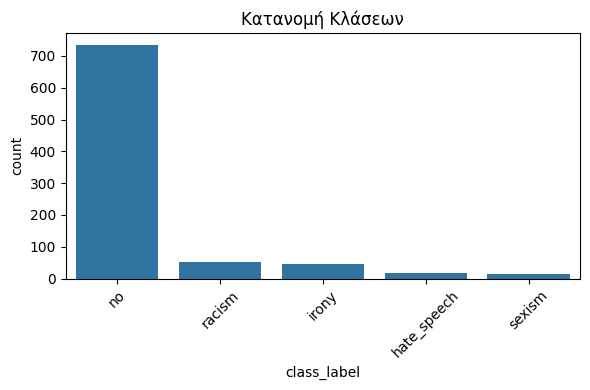


Στατιστικά μήκους κειμένου:
count    866.000000
mean       9.942263
std        8.717739
min        1.000000
25%        4.000000
50%        7.000000
75%       13.000000
max       68.000000
Name: text_length, dtype: float64


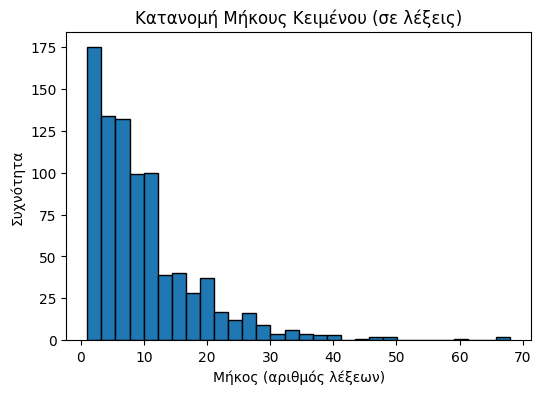

[nltk_data] Downloading package punkt to /home/photo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/photo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Οι 20 πιο συχνές λέξεις:
[('να', 322), ('και', 260), ('το', 244), ('δεν', 235), ('είναι', 198), ('που', 152), ('θα', 116), ('η', 109), ('με', 108), ('την', 106), ('τα', 101), ('αυτό', 95), ('ότι', 95), ('για', 90), ('ο', 85), ('εγώ', 75), ('της', 74), ('σε', 73), ('μου', 73), ('από', 69)]


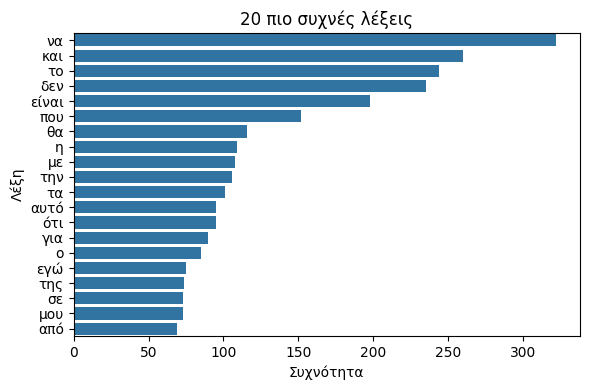

In [70]:
#Κατανομή κλάσης (Class Distribution)
print("Κατανομή κλάσεων:")
print(dataset['class_label'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(data=dataset, x='class_label', order=dataset['class_label'].value_counts().index)
plt.title("Κατανομή Κλάσεων")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Μήκος κειμένου (π.χ. αριθμός λέξεων)
dataset['text_length'] = dataset['cleaned_text'].apply(lambda x: len(x.split()))
print("\nΣτατιστικά μήκους κειμένου:")
print(dataset['text_length'].describe())

plt.figure(figsize=(6, 4))
plt.hist(dataset['text_length'], bins=30, edgecolor='black')
plt.title("Κατανομή Μήκους Κειμένου (σε λέξεις)")
plt.xlabel("Μήκος (αριθμός λέξεων)")
plt.ylabel("Συχνότητα")
plt.show()

# Συχνότητα λέξεων
# Tokenization στο cleaned_text (εάν το θες για ανάλυση συχνότητας)
# Κατέβασμα απαραίτητων πόρων του nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt', quiet=True)
dataset['tokens'] = dataset['cleaned_text'].apply(word_tokenize)

all_tokens = [word for row in dataset['tokens'] for word in row]
counter = Counter(all_tokens)
print("\nΟι 20 πιο συχνές λέξεις:")
print(counter.most_common(20))

# Προαιρετικά, μπορείς να φτιάξεις και ένα απλό barplot για τις πιο συχνές λέξεις:
common_words = counter.most_common(20)
words, freqs = zip(*common_words)
plt.figure(figsize=(6, 4))
sns.barplot(x=list(freqs), y=list(words))
plt.title("20 πιο συχνές λέξεις")
plt.xlabel("Συχνότητα")
plt.ylabel("Λέξη")
plt.tight_layout()
plt.show()

Βήμα 3: Tokenization και Εφαρμογή Stopwords 

In [71]:
# Χρησιμοποίησε το καθαρισμένο κείμενο για tokenization
dataset['tokens'] = dataset['cleaned_text'].apply(word_tokenize)

# (Προαιρετικά) Αφαίρεση πιθανών υπολειπόμενων σημείων στίξης ή αριθμών
dataset['tokens'] = dataset['tokens'].apply(
    lambda tokens: [word for word in tokens if word not in string.punctuation and not word.isdigit()]
)

# Ορισμός και προσαρμογή λίστας stopwords στα Ελληνικά
default_stopwords = set(stopwords.words('greek'))
extra_stopwords = {
    'να', 'και', 'το', 'είναι', 'δεν', 'που', 'την', 'με', 'θα', 'η', 'τα', 'ότι', 'για',
    'μου', 'της', 'αυτό', 'σε', 'από', 'ο', 'Δεν', 'τη', 'τον', 'οι', 'του', 'στην', 'τους',
    'ένα', 'μας', 'στο', 'εγώ', 'έχει', 'σας', 'Και', 'σου', 'τώρα', 'μια', 'Εγώ', 'γιατί',
    'των', 'τι', 'αν', 'αυτή', 'πολύ', 'Να', 'κάτι', 'αυτά', 'Είναι'
}
custom_stopwords = default_stopwords - {"αυτός", "αυτή", "αυτοί"}
custom_stopwords.update(extra_stopwords)

# Ορισμός σημαντικών λέξεων που θέλουμε να κρατήσουμε
important_words = {"ρατσισμός", "σεξισμός", "ξενοφοβία", "κατά", "δικαιώματα", "προσβολή", "διάκριση",
                   "γυναίκα", "άντρας", "μαύρος", "λευκός", "ξένος", "αλλοδαπός"}
custom_stopwords = {word for word in custom_stopwords if word not in important_words}

print("\nΤελική λίστα stopwords:")
print(custom_stopwords)

# Αφαίρεση stopwords από τα tokens
dataset['tokens'] = dataset['tokens'].apply(
    lambda tokens: [word for word in tokens if word not in custom_stopwords]
)

print("\nΠαραδείγματα tokens μετά την εφαρμογή stopwords:")
print(dataset[['cleaned_text', 'tokens']].head())


Τελική λίστα stopwords:
{'ὑπὸ', 'κ', 'ἀπ', 'ὁ', 'τι', 'ἐπὶ', 'ἐπεὶ', 'που', 'καίτοι', 'αυτό', 'πολύ', 'οὐχ', 'μεθ', 'πως', 'τὸν', 'μετὰ', 'αυτα', 'μην', 'ἡ', 'δή', 'κἀν', 'οτι', 'τοτε', 'οὕτωσ', 'οὐχὶ', 'τίς', 'τί', 'Εγώ', 'ἧς', 'εἰσ', 'ἐάν', 'τοιοῦτοσ', 'δαὶ', 'διά', 'τότε', 'ὃ', 'οἷς', 'ἥ', 'εἴμι', 'σύ', 'τοῦ', 'ἐστι', 'ἄρα', 'ἐκ', 'τα', 'μα', 'μετα', 'οὖν', 'ὅστις', 'περί', 'προ', 'τοὺς', 'ἐπί', 'μας', 'ἄλλος', 'γα^', 'ἐξ', 'ὦ', 'ᾧ', 'ποια', 'μη', "δ'", 'ο', 'ἀλλά', 'παρα', 'παρὰ', 'ποιοσ', 'μου', 'ἂν', 'ὑμόσ', 'ἢ', 'ὅστισ', 'ειστε', 'αυτοι', 'τίσ', 'οἱ', 'τὸ', 'αἳ', 'εαν', 'ἀλλὰ', 'τους', 'ὅπερ', 'εἴ', 'ἃ', 'γιατί', 'ειναι', 'ποιοι', 'τὰς', 'ποιουσ', 'ενω', 'αὐτόσ', 'διὰ', 'ποτε', 'εκεινεσ', 'ωσ', 'με', 'τῷ', 'οὗτοσ', 'αἵ', 'ὡσ', 'είναι', 'δαί', 'αυτοσ', 'στη', 'οὐδὲν', 'τὴν', 'ὡς', 'Να', 'ὑπό', 'περὶ', 'εκεινα', 'καὶ', 'τοί', 'των', 'ισωσ', 'εἴτε', 'στο', 'τό', 'ἐγώ', 'ἐφ', 'μετ', 'πρὸ', "ἀλλ'", 'ὃν', 'ὅθεν', 'τισ', 'αυτη', 'δαίσ', 'ὑπὲρ', 'τὰ', 'σὸς', 'οὐδείσ', 'ἄν', 'ἀπό', 'μήτ

Βήμα 4: Undersampling της Κλάσης "no" 

In [72]:
# Εμφάνιση κατανομής κλάσεων πριν το undersampling
print("\nΚατανομή κλάσεων πριν το undersampling:")
print(dataset['class_label'].value_counts())

# Διαχωρισμός των δεδομένων για την κλάση "no" και τις υπόλοιπες κλάσεις
dataset_no = dataset[dataset['class_label'] == 'no']
dataset_other = dataset[dataset['class_label'] != 'no']

# Επιλογή 60 τυχαίων δειγμάτων από την κλάση "no"
dataset_no_sampled = dataset_no.sample(n=60, random_state=42)

# Ενοποίηση με τα δείγματα των υπόλοιπων κλάσεων
dataset_balanced = pd.concat([dataset_no_sampled, dataset_other]).reset_index(drop=True)
print("\nΚατανομή κλάσεων μετά το undersampling:")
print(dataset_balanced['class_label'].value_counts())


Κατανομή κλάσεων πριν το undersampling:
class_label
no             736
racism          52
irony           46
hate_speech     17
sexism          15
Name: count, dtype: int64

Κατανομή κλάσεων μετά το undersampling:
class_label
no             60
racism         52
irony          46
hate_speech    17
sexism         15
Name: count, dtype: int64


Βήμα 5: Προετοιμασία Κειμένου για TF-IDF 

In [73]:
# Ενώνουμε τα tokens για κάθε δείγμα ώστε να δημιουργήσουμε το κείμενο για το TF-IDF
dataset_balanced['processed_text'] = dataset_balanced['tokens'].apply(lambda tokens: ' '.join(tokens))



Βήμα 6: Μετατροπή σε Χαρακτηριστικά με TF-IDF 

In [74]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(dataset_balanced['processed_text'])
y = dataset_balanced['class_label']

print("\nΜορφή του TF-IDF Feature Matrix:", X.shape)


Μορφή του TF-IDF Feature Matrix: (190, 920)


Βήμα 7: Μείωση Διαστάσεων με PCA και Οπτικοποίηση 

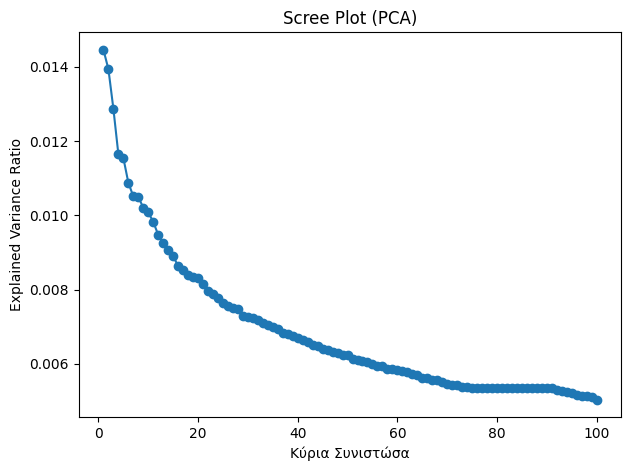

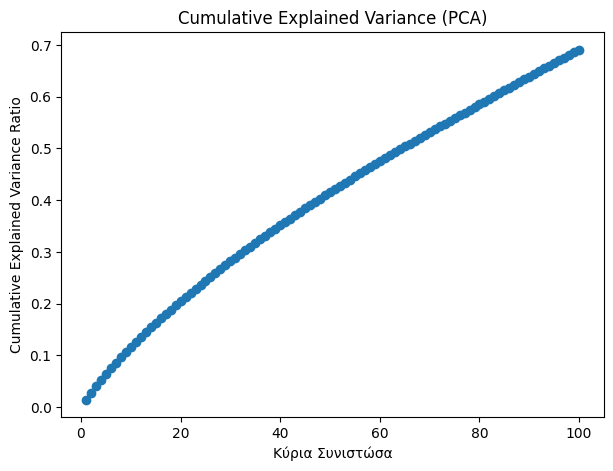

In [75]:
pca = PCA(n_components=100, random_state=42)
X_reduced = pca.fit_transform(X)

# Δημιουργία Scree Plot: Εξηγούμενη διακύμανση για κάθε κύρια συνιστώσα
exp_var_ratio = pca.explained_variance_ratio_
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(exp_var_ratio) + 1), exp_var_ratio, marker='o')
plt.title('Scree Plot (PCA)')
plt.xlabel('Κύρια Συνιστώσα')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Διάγραμμα σωρευτικής εξηγούμενης διακύμανσης
cum_exp_var = np.cumsum(exp_var_ratio)
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(cum_exp_var) + 1), cum_exp_var, marker='o')
plt.title('Cumulative Explained Variance (PCA)')
plt.xlabel('Κύρια Συνιστώσα')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

Βήμα 8: Ταξινόμηση με Leave-One-Out Cross-Validation 

In [76]:
# Δημιουργούμε ένα pipeline που ενσωματώνει το PCA και την Logistic Regression
loo = LeaveOneOut()
pipeline = Pipeline([
    ('pca', PCA(n_components=60, random_state=42)),  # Επιλογή 60 συνιστωσών ως παράδειγμα
    ('clf', LogisticRegression(max_iter=1000))
])

# Εφαρμογή Leave-One-Out Cross-Validation για πρόβλεψη
y_pred = cross_val_predict(pipeline, X, y, cv=loo)
cm = confusion_matrix(y, y_pred)

# Υπολογισμός μετρικών απόδοσης
precision = precision_score(y, y_pred, average='macro')
recall = recall_score(y, y_pred, average='macro')
f1 = f1_score(y, y_pred, average='macro')

print("\nΑποτελέσματα Απόδοσης:")
print("Precision (macro):", precision)
print("Recall (macro):   ", recall)
print("F1 (macro):       ", f1)
print("\nClassification report:")
print(classification_report(y, y_pred))


Αποτελέσματα Απόδοσης:
Precision (macro): 0.27837008628954935
Recall (macro):    0.259453734671126
F1 (macro):        0.20995477601648202

Classification report:
              precision    recall  f1-score   support

 hate_speech       0.00      0.00      0.00        17
       irony       0.50      0.07      0.12        46
          no       0.35      0.87      0.50        60
      racism       0.54      0.37      0.44        52
      sexism       0.00      0.00      0.00        15

    accuracy                           0.39       190
   macro avg       0.28      0.26      0.21       190
weighted avg       0.38      0.39      0.30       190



/home/photo/Desktop/ML Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/photo/Desktop/ML Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/photo/Desktop/ML Project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Confusion Matrix

Confusion Matrix:
[[ 0  0 16  1  0]
 [ 0  3 36  7  0]
 [ 0  2 52  6  0]
 [ 0  1 32 19  0]
 [ 0  0 13  2  0]]


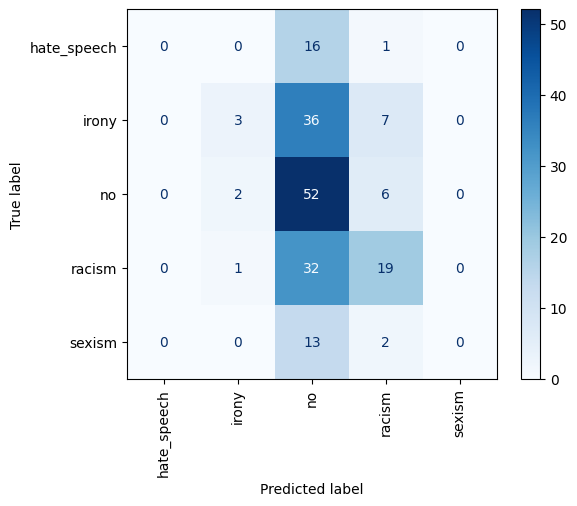

In [66]:
print("Confusion Matrix:")
print(cm)

# Οπτικοποίηση του confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap="Blues", xticks_rotation='vertical')